In [2]:
##importação de bibliotecas e definições gerais

import matplotlib.pyplot as plt

import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

pd.options.display.float_format = '{:.2f}'.format

In [3]:
tipos = {
    'bugged_date': 'category',
    'deputy_id': np.int64,
    'political_party': 'category',
    'state_code': 'category',
    'deputy_name': object,
    'receipt_social_security_number': object,
    'receipt_description': object,
    'establishment_name': object,
    'receipt_value': np.float64
}
reembolsos = pd.read_csv('./deputies_reimbursements/deputies_dataset.csv', dtype=tipos, parse_dates=['receipt_date'])
reembolsos['receipt_year'] = pd.DatetimeIndex(reembolsos['receipt_date']).year
reembolsos['receipt_month'] = pd.DatetimeIndex(reembolsos['receipt_date']).month
reembolsos['receipt_day_of_month'] = pd.DatetimeIndex(reembolsos['receipt_date']).day

In [4]:
reembolsos.dtypes

bugged_date                             category
receipt_date                      datetime64[ns]
deputy_id                                  int64
political_party                         category
state_code                              category
deputy_name                               object
receipt_social_security_number            object
receipt_description                       object
establishment_name                        object
receipt_value                            float64
receipt_year                               int64
receipt_month                              int64
receipt_day_of_month                       int64
dtype: object

In [5]:
reembolsos.describe()

,deputy_id,receipt_value,receipt_year,receipt_month,receipt_day_of_month
count,3014902.00,3014902.00,3014902.00,3014902.00,3014902.00
mean,1869.10,579.16,2012.99,6.48,14.87
std,701.48,1925.42,2.46,3.30,9.00
min,12.00,0.00,2009.00,1.00,1.00
25%,1467.00,50.00,2011.00,4.00,7.00
50%,1882.00,142.00,2013.00,6.00,15.00
75%,2340.00,472.00,2015.00,9.00,23.00
max,3173.00,215000.00,2017.00,12.00,31.00


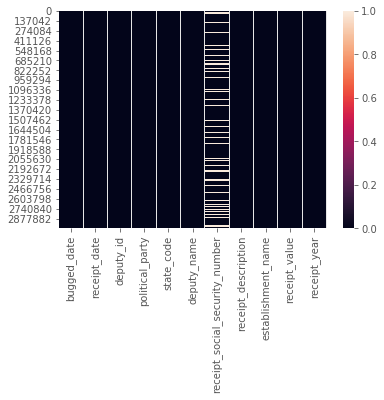

In [6]:
sns.heatmap(reembolsos.isnull())

In [6]:
# Não estou interessado em recibos em que eu não consiga identificar o CNPJ/CPF do estabelecimento, apesar disso, eventualmente 
# poderíamos avaliar o que consta aqui.
reembolsos.loc[reembolsos['receipt_social_security_number'].isnull()].describe()

,deputy_id,receipt_value,receipt_year,receipt_month,receipt_day_of_month
count,520952.00,520952.00,520952.00,520952.00,520952.00
mean,1743.67,206.05,2012.42,6.33,14.09
std,694.87,723.95,2.35,3.56,9.28
min,12.00,0.00,2009.00,1.00,1.00
25%,1311.00,25.00,2010.00,3.00,6.00
50%,1825.00,57.00,2012.00,6.00,14.00
75%,2276.00,193.00,2014.00,9.00,22.00
max,3173.00,149754.00,2017.00,12.00,31.00


C:\Users\Marco\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Marco\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


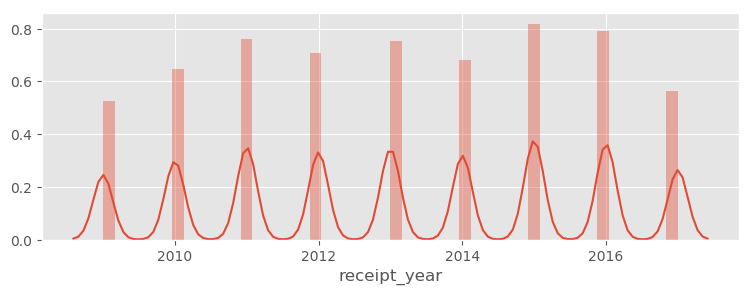

In [43]:
fig = plt.figure(figsize=(9,3), dpi=100)
sns.distplot(reembolsos['receipt_year'])


In [7]:
# Removendo recibos sem cpf/cnpj do fornecedor
# Também não tenho interesse em avaliar recibos com valor igual a 0.
reembolsos = reembolsos.loc[ (~ reembolsos['receipt_social_security_number'].isnull())]
reembolsos = reembolsos.loc[ (reembolsos['receipt_value']!=0)]
reembolsos.describe()

,deputy_id,receipt_value,receipt_year,receipt_month,receipt_day_of_month
count,2492434.00,2492434.00,2492434.00,2492434.00,2492434.00
mean,1895.31,657.49,2013.11,6.52,15.03
std,699.98,2083.12,2.47,3.24,8.93
min,12.00,1.00,2009.00,1.00,1.00
25%,1531.00,63.00,2011.00,4.00,7.00
50%,1896.00,160.00,2013.00,6.00,15.00
75%,2349.00,543.00,2015.00,9.00,23.00
max,3173.00,215000.00,2017.00,12.00,31.00


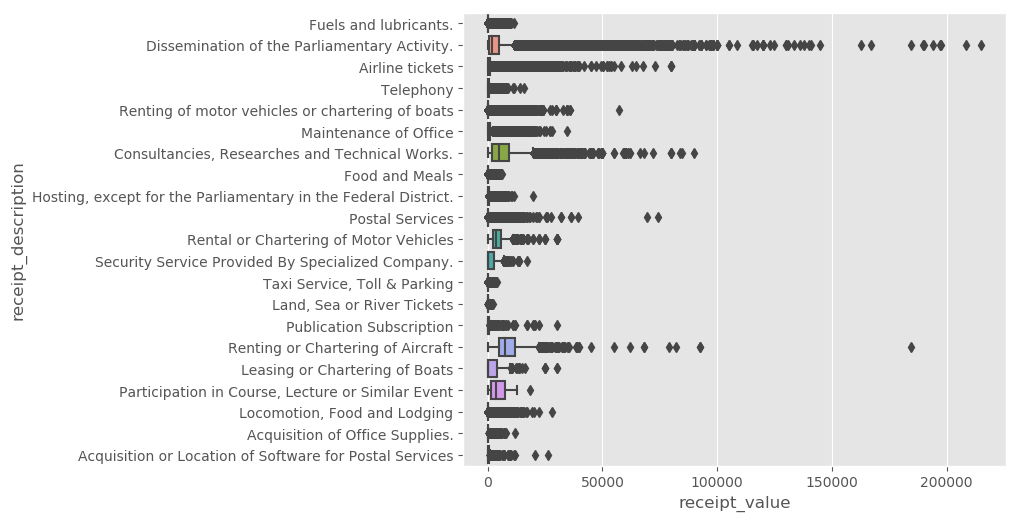

In [8]:
# Avaliação sobre a distribuição de valores em função do tipo de gasto
fig = plt.figure(figsize=(7,6), dpi=100)
sns.boxplot(data=reembolsos, y='receipt_description', x='receipt_value')

In [7]:
reembolsos.shape

(2492434, 13)

In [9]:
# Vou concentrar a análise abandonando os outliers.

def get_outlier_media(s, sd_q_out=3.0):
    """
    Return boolean qualifier for outliers from a pandas series
    using standard deviation.
    param sd_q_out:
        Standard deviation multiplier factor to qualify as outlier.
    :type sd_q_out: ``float``
    """
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * sd_q_out
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    return [True if x < lower or x > upper else False for x in s]

def get_outlier_interquartil(s, k=1.5):
    """
    Return a boolean qualifier for outliers from a pandas series
    using interquartile range.
    param k:
        Multiplier factor to qualify as outlier
    :type k: ``float``
    """
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    
    return [True if x < lower or x > upper else False for x in s]

In [10]:
reembolsos['oulier_interquartil'] = get_outlier_interquartil(reembolsos['receipt_value'])
reembolsos['oulier_std_deviation'] = get_outlier_media(reembolsos['receipt_value'])

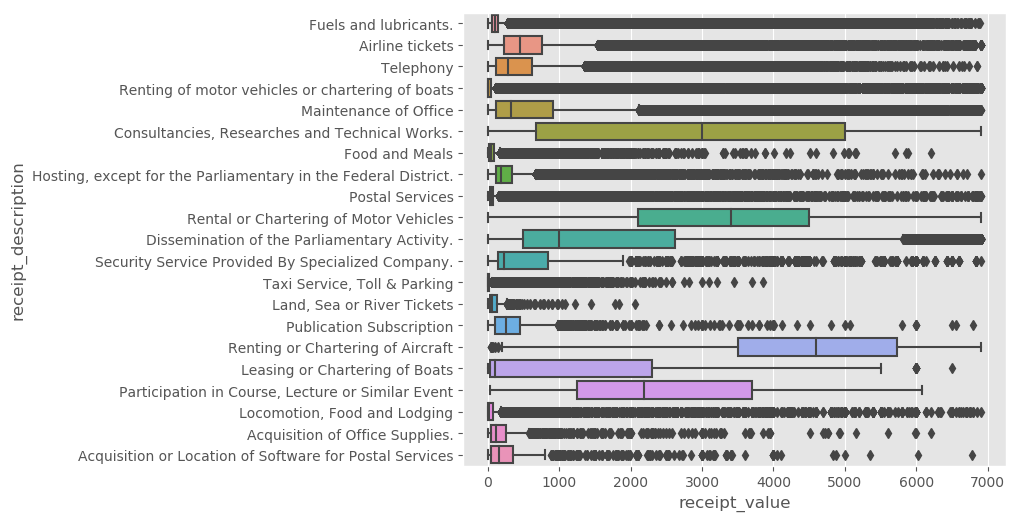

In [13]:
fig = plt.figure(figsize=(7,6), dpi=100)
sns.boxplot(data=reembolsos[~reembolsos['oulier_std_deviation']], x='receipt_value', y='receipt_description')

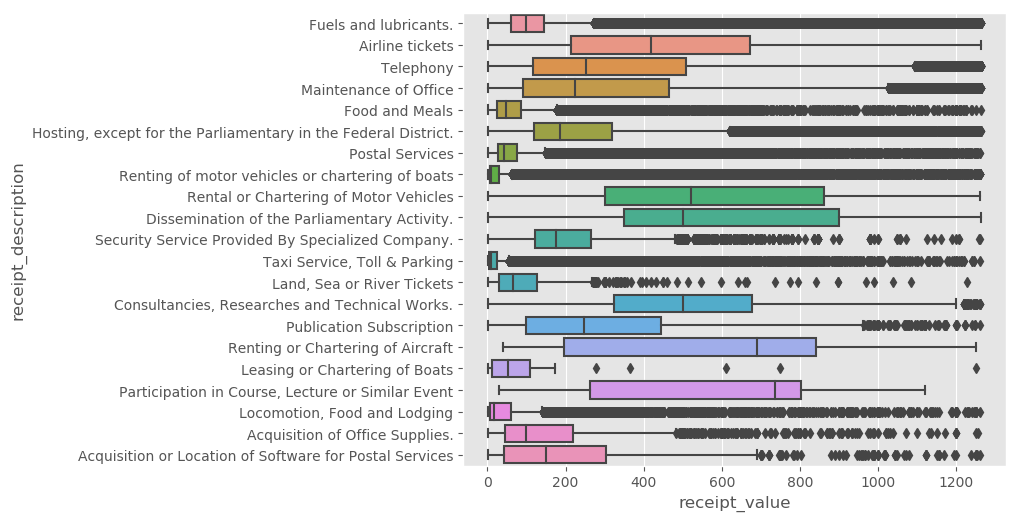

In [14]:
fig = plt.figure(figsize=(7,6), dpi=100)
sns.boxplot(data=reembolsos[~reembolsos['oulier_interquartil']], x='receipt_value', y='receipt_description')

In [17]:
reembolsos_regular = reembolsos[~reembolsos['oulier_interquartil']]
reembolsos_regular.shape

(2238768, 15)

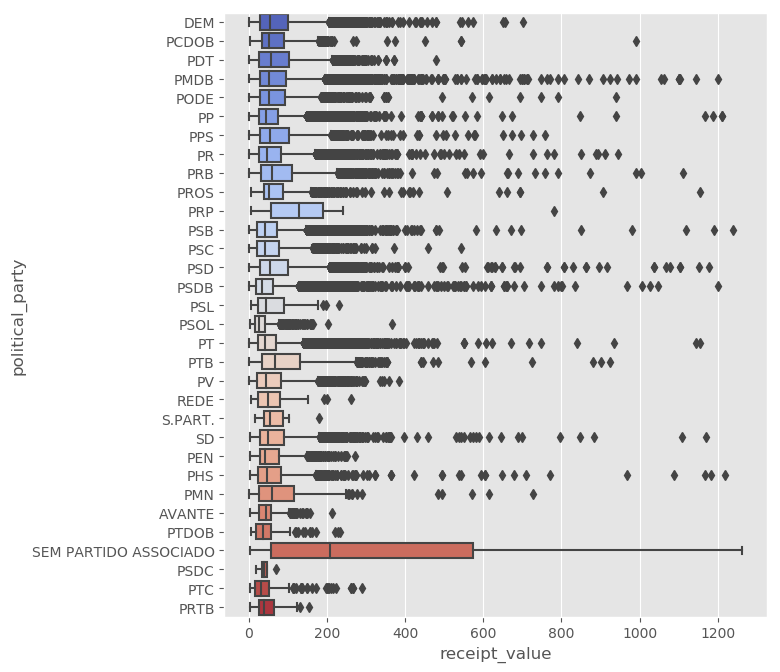

In [39]:
# reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Consultancies, Researches and Technical Works.']
# reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Fuels and lubricants.']
# reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Leasing or Chartering of Boats']
# reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Dissemination of the Parliamentary Activity.']
reembolso_sub_analise = reembolsos_regular[reembolsos_regular['receipt_description']=='Food and Meals']

fig = plt.figure(figsize=(7,8), dpi=100)
sns.boxplot(x="receipt_value", y="political_party",data=reembolso_sub_analise, palette="coolwarm")

In [50]:
reembolso_sub_analise = reembolso_sub_analise[reembolso_sub_analise['receipt_year'] == 2015]

In [51]:
len(reembolso_sub_analise['receipt_social_security_number'].unique())

5920

In [60]:
# reemb_dummie_party = pd.get_dummies(reembolso_sub_analise['political_party']).drop(['SEM PARTIDO ASSOCIADO','S.PART.'], axis=1)
# reemb_dummie_state = pd.get_dummies(reembolso_sub_analise['state_code']).drop('Vazio', axis=1)
reemb_dummie = reembolso_sub_analise.iloc[:,[2,3,4,5,6,9,10,11,12]]
reemb_dummie.head()

,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_value,receipt_year,receipt_month,receipt_day_of_month
1068417,3074,DEM,RR,Abel Mesquita Jr.,3070459000150.0,62.00,2015,10,29
1068418,3074,DEM,RR,Abel Mesquita Jr.,1552582000181.0,134.00,2015,10,22
1068419,3074,DEM,RR,Abel Mesquita Jr.,33469172001644.0,50.00,2015,11,11
1068830,3016,PP,CE,Adail Carneiro,7166985000179.0,150.00,2015,9,28
1068831,3016,PP,CE,Adail Carneiro,35401470000141.0,90.00,2015,6,15


In [63]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(reemb_dummie['deputy_id'])
reemb_dummie['deputy_id_'] = le.transform(reemb_dummie['deputy_id'])

le.fit(reemb_dummie['political_party'])
reemb_dummie['political_party_'] = le.transform(reemb_dummie['political_party'])

le.fit(reemb_dummie['state_code'])
reemb_dummie['state_code_'] = le.transform(reemb_dummie['state_code'])

le.fit(reemb_dummie['receipt_social_security_number'])
reemb_dummie['receipt_social_security_number_'] = le.transform(reemb_dummie['receipt_social_security_number'])
reemb_dummie.head()

C:\Users\Marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_value,receipt_year,receipt_month,receipt_day_of_month,deputy_id_,political_party_,state_code_,receipt_social_security_number_
1068417,3074,DEM,RR,Abel Mesquita Jr.,3070459000150.0,62.00,2015,10,29,469,1,21,2857
1068418,3074,DEM,RR,Abel Mesquita Jr.,1552582000181.0,134.00,2015,10,22,469,1,21,1351
1068419,3074,DEM,RR,Abel Mesquita Jr.,33469172001644.0,50.00,2015,11,11,469,1,21,3002
1068830,3016,PP,CE,Adail Carneiro,7166985000179.0,150.00,2015,9,28,422,9,5,4529
1068831,3016,PP,CE,Adail Carneiro,35401470000141.0,90.00,2015,6,15,422,9,5,3101


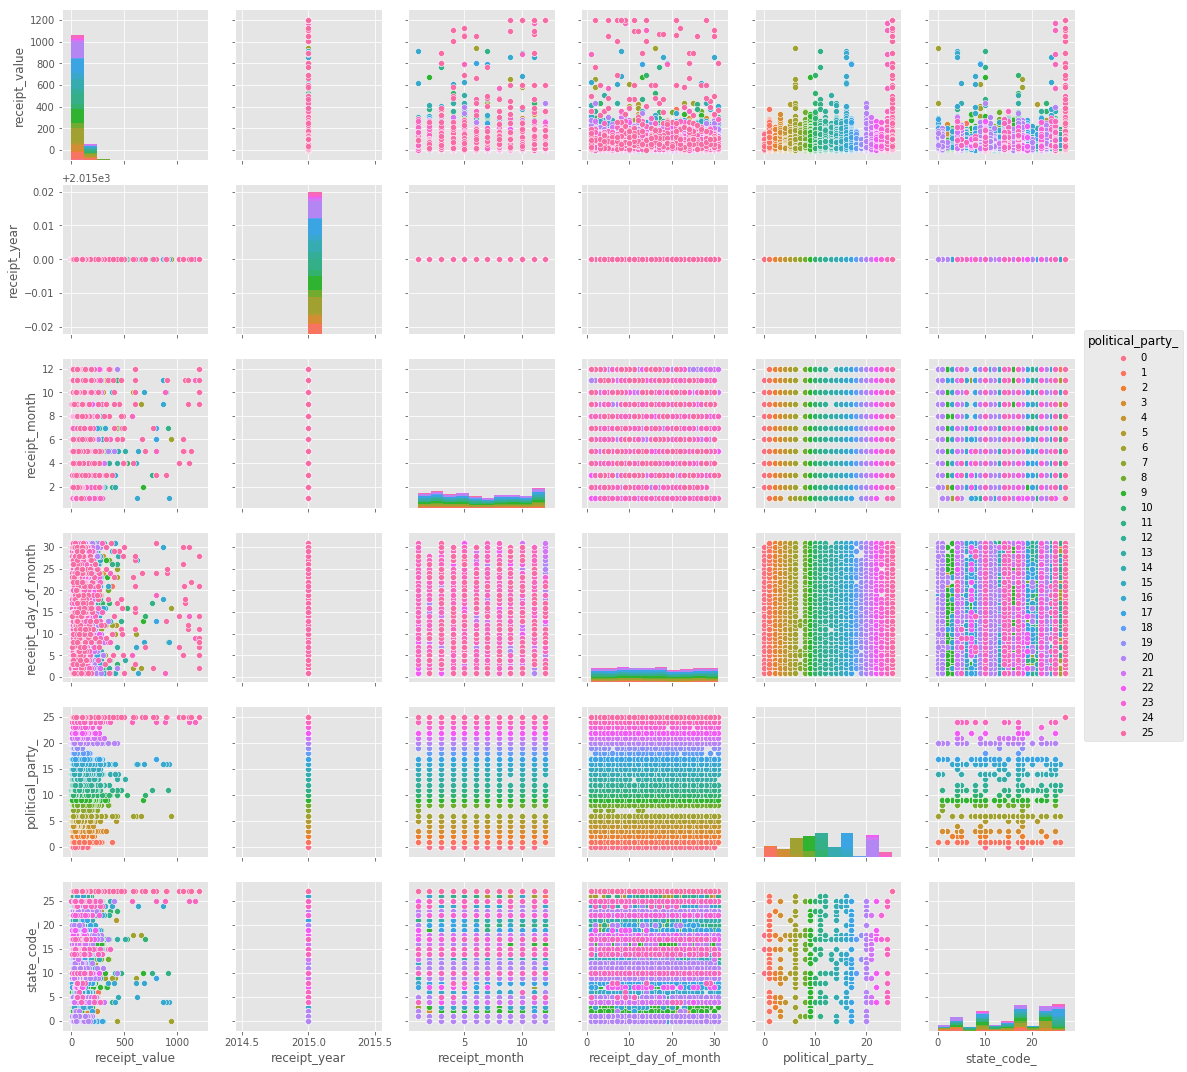

In [67]:
sns.pairplot(reemb_dummie.iloc[:,[5,6,7,8,10,11]], hue='political_party_')

In [22]:
from sklearn.model_selection import train_test_split

reemb_dummie = pd.concat([reemb_dummie,reemb_dummie_party, reemb_dummie_state], axis=1)
reemb_dummie_y = reemb_dummie['receipt_value']
reemb_dummie_X = reemb_dummie.drop('receipt_value', axis=1)


X_train, X_test, y_train, y_test = train_test_split(reemb_dummie_X, reemb_dummie_y, test_size=0.4, random_state=101)